In [46]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

from myutil import *
from features import get_all_features

# Suppress warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

df = pd.read_csv('data/data.csv')

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
#df['risk_score_t'] = df['risk_score_t'].apply(lambda x: 0.1 if x < 0.1 else x)
df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)

cuda


In [47]:
# subset a sample of 5000 rows of df
df = df.sample(n=5000, random_state=1)

df.shape

(5000, 168)

In [48]:
# Group risk score and g_continuous by race and calculate mean
grouped_stats = df.groupby('race')[['risk_score_t', 'g_continuous', 'cost_avoidable_t', 'screening_eligible', 'propensity_score']].agg(['mean'])

# Identify the number of people in each race
race_counts = df['race'].value_counts()
print("Number of people in each race:")
print(race_counts)

# Add a column for the number of people
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
grouped_stats['Count'] = race_counts

# Move the 'Count' column to the front
cols = grouped_stats.columns.tolist()
cols = ['Count'] + [col for col in cols if col != 'Count']
grouped_stats = grouped_stats[cols]

# Change the columns names to be meaningful
grouped_stats.columns = ['Count', 'Risk Score', 'Gain Factor', 'Avoidable Costs', 'Screening Eligible', 'Propensity Score']

# Change the index to 'White' and 'Black'
grouped_stats.index = ['White', 'Black']

# round all numbers to 2 decimal places
grouped_stats = grouped_stats.round(2)
print("\nDataset Statistics by Race (mean):")
print(grouped_stats)

latex_table = grouped_stats.to_latex(index=True, column_format='lcccccc', 
                                     caption='Descriptive statistics of Dataset', label='tab:descriptive_stats', float_format="%.2f")
print(latex_table)
grouped_stats


Number of people in each race:
race
0    4432
1     568
Name: count, dtype: int64

Dataset Statistics by Race (mean):
       Count  Risk Score  Gain Factor  Avoidable Costs  Screening Eligible  \
White   4432        4.31        58.82          2269.34                0.46   
Black    568        5.45        77.36          3544.37                0.49   

       Propensity Score  
White              0.45  
Black              0.50  
\begin{table}
\caption{Descriptive statistics of Dataset}
\label{tab:descriptive_stats}
\begin{tabular}{lcccccc}
\toprule
 & Count & Risk Score & Gain Factor & Avoidable Costs & Screening Eligible & Propensity Score \\
\midrule
White & 4432 & 4.31 & 58.82 & 2269.34 & 0.46 & 0.45 \\
Black & 568 & 5.45 & 77.36 & 3544.37 & 0.49 & 0.50 \\
\bottomrule
\end{tabular}
\end{table}



,Count,Risk Score,Gain Factor,Avoidable Costs,Screening Eligible,Propensity Score
White,4432,4.31,58.82,2269.34,0.46,0.45
Black,568,5.45,77.36,3544.37,0.49,0.50


In [49]:
grouped_stats = df.groupby('race')[['risk_score_t', 'g_continuous', 'cost_avoidable_t', 'screening_eligible', 'propensity_score']].agg(['std'])
race_counts = df['race'].value_counts()
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
grouped_stats['Count'] = race_counts
cols = grouped_stats.columns.tolist()
cols = ['Count'] + [col for col in cols if col != 'Count']
grouped_stats = grouped_stats[cols]
grouped_stats.columns = ['Count', 'Risk Score', 'Gain Factor', 'Avoidable Costs', 'Screening Eligible', 'Propensity Score']
grouped_stats.index = ['White', 'Black']
grouped_stats = grouped_stats.round(2)
print("\nDataset Statistics by Race (std):")
print(grouped_stats)
latex_table = grouped_stats.to_latex(index=True, column_format='lcccccc', caption='Descriptive statistics of Dataset', label='tab:descriptive_stats', float_format="%.2f")
print(latex_table)
grouped_stats


Number of people in each race:
race
0    4432
1     568
Name: count, dtype: int64

Dataset Statistics by Race (std):
       Count  Risk Score  Gain Factor  Avoidable Costs  Screening Eligible  \
White   4432        5.27       291.58         11638.21                 0.5   
Black    568        8.11       428.94         15655.29                 0.5   

       Propensity Score  
White              0.37  
Black              0.38  
\begin{table}
\caption{Descriptive statistics of Dataset}
\label{tab:descriptive_stats}
\begin{tabular}{lcccccc}
\toprule
 & Count & Risk Score & Gain Factor & Avoidable Costs & Screening Eligible & Propensity Score \\
\midrule
White & 4432 & 5.27 & 291.58 & 11638.21 & 0.50 & 0.37 \\
Black & 568 & 8.11 & 428.94 & 15655.29 & 0.50 & 0.38 \\
\bottomrule
\end{tabular}
\end{table}



,Count,Risk Score,Gain Factor,Avoidable Costs,Screening Eligible,Propensity Score
White,4432,5.27,291.58,11638.21,0.5,0.37
Black,568,8.11,428.94,15655.29,0.5,0.38


In [19]:
0.08 * 100

8.0

Risk Score Statistics by Race:
          mean       std  count
race                           
0     4.305167  5.271175   4432
1     5.450928  8.105524    568

t-test Results:
t-statistic: -4.5386
p-value: 0.0000


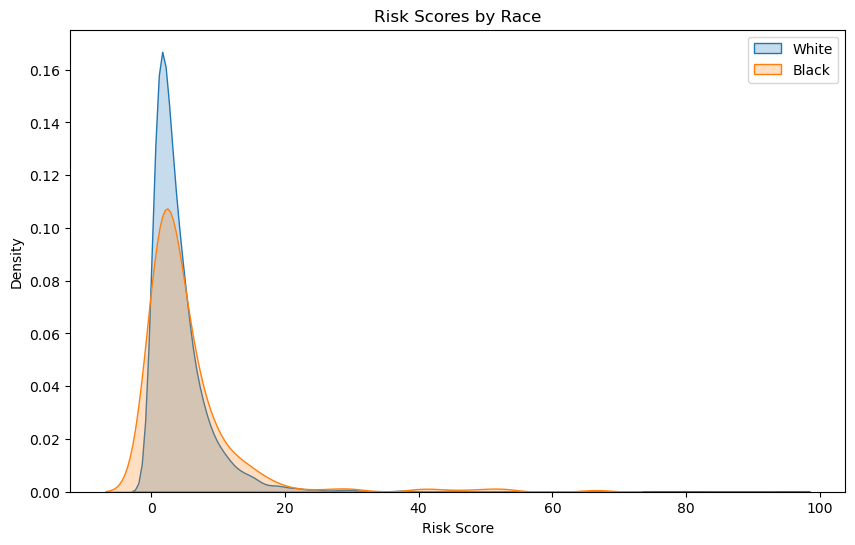

In [20]:
import seaborn as sns
import scipy.stats as stats

# Calculate mean risk scores by race
risk_by_race = df.groupby('race')['risk_score_t'].agg(['mean', 'std', 'count'])
print("Risk Score Statistics by Race:")
print(risk_by_race)

# Perform a t-test to check if the difference is statistically significant
white_risk = df[df['race'] == 0]['risk_score_t']
black_risk = df[df['race'] == 1]['risk_score_t']
t_stat, p_value = stats.ttest_ind(white_risk, black_risk)

print("\nt-test Results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Visualize the distribution using KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(white_risk, label='White', shade=True)
sns.kdeplot(black_risk, label='Black', shade=True)
plt.title('Risk Scores by Race')
plt.xlabel('Risk Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
alpha = 2
Q = 10

In [22]:
# Define input variables for DFL
feats = df[get_all_features(df)].values
risk = df['risk_score_t'].values

risk = risk + 0.001

gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.ones(risk.shape)
race = df['race'].values

# transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

from sklearn.model_selection import train_test_split

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, df['race'].values, test_size=0.4, random_state=42
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

Train size: 3000
Test size: 2000


In [23]:
def AlphaFairness(util, alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha) / (1-alpha))

def solve_optimization(gainF, risk, cost, alpha=alpha, Q=Q):
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost

    risk = risk.clip(min=0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")

    utils = cp.multiply(cp.multiply(gainF, risk), d)
    constraints = [d >= 0, cp.sum(cost * d) <= Q]

    if alpha == 'inf':
        t = cp.Variable()
        objective = cp.Maximize(t)
        constraints.append(utils >= t)
    elif alpha == 1:
        objective = cp.Maximize(cp.sum(cp.log(utils)))
    elif alpha == 0:
        objective = cp.Maximize(cp.sum(utils))
    else:
        objective = cp.Maximize(cp.sum(utils**(1-alpha)) / (1-alpha))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=False, warm_start=True, mosek_params={'MSK_IPAR_LOG': 1})

    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")

    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)

    return optimal_decision, optimal_value


In [24]:
# Define the prediction model
class FairRiskDataset(Dataset):
    def __init__(self, features, races, risks):
        self.features = torch.FloatTensor(features)
        self.races = torch.LongTensor(races)
        self.risks = torch.FloatTensor(risks).reshape(-1, 1)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.races[idx], self.risks[idx]

class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Softplus()
        )
        
    def forward(self, x):
        return self.model(x)
        
def train_fair_model(features, races, risks, epochs=20, batch_size=32, lambda_fairness=0):
    """
    Train a fair regression model with a fairness regularizer.
    
    Args:
        features (np.ndarray): Feature array.
        races (np.ndarray): Array indicating race (0: white, 1: black).
        risks (np.ndarray): True risk values.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        lambda_fairness (float): Weight for the fairness regularizer.
        
    Returns:
        nn.Module: Trained fair regression model.
    """
    dataset = FairRiskDataset(features, races, risks)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = FairRiskPredictor(features.shape[1])
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_features, batch_races, batch_risks in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_features)
            mse_loss = criterion(predictions, batch_risks)
            
            # Compute fairness loss
            group0 = predictions[batch_races == 0]
            group1 = predictions[batch_races == 1]
            if len(group0) > 0 and len(group1) > 0:
                fairness_loss = torch.abs(group0.mean() - group1.mean())
            else:
                fairness_loss = torch.tensor(0.0)
            
            # Total loss
            total_loss = mse_loss + lambda_fairness * fairness_loss
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            avg_loss = epoch_loss / len(dataloader)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return model


# Train the fair model
# model = train_fair_model(feats_train, race, risk_train, epochs=20, lambda_fairness=0).to(device)
# model.eval()

# # save
# torch.save(model.state_dict(), 'risk_predictor_model.pth')


# load model from disk
model = FairRiskPredictor(feats.shape[1])
model.load_state_dict(torch.load('risk_predictor_model.pth'))
model.to(device)
model.eval()

FairRiskPredictor(
  (model): Sequential(
    (0): Linear(in_features=149, out_features=1, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [25]:
# Dataset
class FairDFLDataset(Dataset):
    def __init__(self, features, risk, gainF, cost, race, alpha=alpha, Q=Q):
        self.features = features
        self.risk = risk
        self.gainF = gainF
        self.cost = cost
        self.race = race
        self.alpha = alpha
        self.Q = Q

        self.sols, self.vals = self._get_solutions()
        self._to_tensor()

    def __len__(self):
        return len(self.features)

    def _get_solutions(self):
        sols, vals = solve_optimization(self.gainF, self.risk, self.cost, self.alpha, self.Q)
        return sols, vals

    def _to_tensor(self):
        self.features = torch.FloatTensor(self.features)
        self.risk = torch.FloatTensor(self.risk)
        self.gainF = torch.FloatTensor(self.gainF)
        self.cost = torch.FloatTensor(self.cost)
        self.race = torch.LongTensor(self.race)
        self.sols = torch.FloatTensor(self.sols)
        self.vals = torch.FloatTensor([self.vals])

    def __getitem__(self, idx):
        return self.features[idx], self.risk[idx], self.gainF[idx], self.cost[idx], self.race[idx], self.sols[idx], self.vals

# test the dataset and dataloader
dataset_train = FairDFLDataset(feats_train, risk_train, gainF_train, cost_train, race_train)
dataset_test = FairDFLDataset(feats_test, risk_test, gainF_test, cost_test, race_test)

# Load the dataset into a DataLoader
loader_train = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)
print('The current alpha and Q values are:', alpha, Q)

The current alpha and Q values are: 2 10


In [26]:
def regret(predModel, optModel, dataloader, alphas=[alpha], Q=Q):
    predModel.eval()
    features, risk, gainF, cost, race, true_sols, true_vals = next(iter(dataloader))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features, risk, gainF, cost, race, true_sols, true_vals = (
        features.to(device),
        risk.to(device),
        gainF.to(device),
        cost.to(device),
        race.to(device),
        true_sols.to(device),
        true_vals.to(device),
    )

    with torch.no_grad():
        pred_risk = predModel(features).clamp(min=0.001)
    risk = risk.clamp(min=0.001)

    pred_risk = pred_risk.cpu().numpy()
    risk = risk.cpu().numpy()
    gainF = gainF.cpu().numpy()
    cost = cost.cpu().numpy()

    regrets = []
    for alpha in alphas:
        true_sol, true_obj = optModel(gainF, risk, cost, alpha, Q)
        pred_sol, _ = optModel(gainF, pred_risk, cost, alpha, Q)
        pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)
        normalized_regret = (true_obj - pred_obj) / (abs(true_obj) + 1e-7)
        regrets.append(normalized_regret)

    predModel.train()
    return np.mean(regrets)

In [27]:
import numpy as np

def compute_d_star_closed_form(g, r, c, alpha=alpha, Q=Q):

    if not isinstance(c, np.ndarray) or not isinstance(r, np.ndarray) or not isinstance(g, np.ndarray):
        raise TypeError("c, r, and g must be numpy arrays.")
    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
        
    return d_star_closed


In [28]:
import numpy as np

def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    n = len(c)
    gradient = np.zeros((n, n))
    
    # Compute S where necessary
    if alpha == 1 or alpha == 'inf':
        S = np.sum(c / (r * g))
    elif isinstance(alpha, (int, float)) and alpha > 0 and alpha !=1:
        S = np.sum((c / (r * g))** (1 / alpha))
    
    if alpha == 0:
        # Utilitarian case: Allocate everything to the individual with the highest ratio
        ratios = (r * g) / c
        i_star = np.argmax(ratios)
        # Gradient is Q * g_i / c_i at the allocated index, zero elsewhere
        gradient[i_star, i_star] = Q * g[i_star] / c[i_star]
        return gradient

    elif alpha == 1:
        # Nash welfare case
        # d_i* = (Q / S) * (1 / c_i)
        # ∂d_i*/∂r_k = Q * c_k / (c_i * r_k * g_k * S^2)
        for i in range(n):
            for k in range(n):
                gradient[i, k] = (Q * c[k]) / (c[i] * r[k] * g[k] * S**2)
        return gradient

    elif alpha == 'inf':
        # Maximin fairness case
        # d_i* = (Q / S) * (1 / (r_i * g_i))
        # ∂d_i*/∂r_k = 
        #   -Q / (r_i * g_i * S^2) if i == k
        #   Q * c_k / (r_k * g_k)^2 / (r_i * g_i * S^2) if i != k
        for i in range(n):
            for k in range(n):
                if i == k:
                    gradient[i, k] = -Q / (r[i] * g[i] * S**2)
                else:
                    gradient[i, k] = (Q * c[k]) / ((r[k] * g[k])**2 * r[i] * g[i] * S**2)
        return gradient

    else:
        # General alpha case: alpha >0, alpha !=1
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")
        
        # d_i* = ( (r_i * g_i / c_i)^(1/alpha) ) / S * Q
        # ∂d_i*/∂r_k = Q / S * (1/alpha) * (r_i * g_i / c_i)^(1/alpha -1) * (g_i / c_i if i ==k else 0) 
        # - Q / S^2 * ( (r_i * g_i / c_i)^(1/alpha) ) * ( (1/alpha) * (c_k / (r_k^2 * g_k)) * (r_k * g_k / c_k)^(1/alpha -1) ) )
        
        # Precompute terms
        term = (r * g) / c  # Shape: (n,)
        term_alpha = term**(1/alpha)  # Shape: (n,)
        d_star = (term_alpha / S) * Q  # Shape: (n,)
        
        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_k = (1/alpha) * (r_i * g_i / c_i)^(1/alpha -1) * (g_i / c_i) * Q / S
                    partial1 = (1.0 / alpha) * (term[i]**(1/alpha -1)) * (g[i] / c[i]) * Q / S
                else:
                    # ∂d_i*/∂r_k = - (term_alpha[i] * (1/alpha) * (c[k] / (r[k]**2 * g[k])) ) * Q / S^2
                    partial1 = 0  # Since d_i* does not directly depend on r_k when i !=k in this term
                # Now, the derivative of 1/S with respect to r_k:
                # ∂(1/S)/∂r_k = - (c_k / (r_k**2 * g_k)) / S^2
                partial2 = - (c[k] / (r[k]**2 * g[k])) / (S**2)
                
                # ∂d_i*/∂r_k = term_alpha[i] * partial2 * Q
                gradient[i, k] = term_alpha[i] * partial2 * Q
                
                if i == k:
                    gradient[i, k] += (1.0 / alpha) * (term[i]**(1/alpha -1)) * (g[i] / c[i]) * Q / S
        
        return gradient


In [39]:
alpha='inf'

In [40]:
sol_c = compute_d_star_closed_form(gainF, risk, cost, alpha, Q)
val_c = AlphaFairness(gainF * risk * sol_c, alpha)
sol_c, val_c

(array([1.35936748e-06, 1.41622196e-06, 2.22831948e-07, ...,
        1.04090382e-05, 3.22113696e-07, 7.40413659e-06]),
 3.5629623538986714e-05)

In [41]:
sol, val = solve_optimization(gainF, risk, cost, alpha, Q)
sol, val

(array([1.35965938e-06, 1.41653318e-06, 2.23289181e-07, ...,
        1.04097102e-05, 3.22549377e-07, 7.40455122e-06]),
 3.562961372709927e-05)

In [42]:
np.allclose(sol, sol_c, atol=1e-3), np.isclose(val, val_c)

(True, True)

In [32]:
difference = np.abs(sol - sol_c) / (np.abs(sol_c) + 1e-7)
difference.sum()

percent_difference = difference.sum() * 100
print('percent difference:', percent_difference)

percent difference: 110082.6060680282


In [33]:
grad_c = compute_gradient_closed_form(gainF, risk, cost, alpha, Q) 
grad_c

array([[ 3.79736585e-03, -7.90422906e-08, -8.77843619e-08, ...,
        -5.68945485e-08, -3.41784726e-08, -1.13557682e-07],
       [-6.44263625e-08,  4.29229078e-03, -8.60042539e-08, ...,
        -5.57408300e-08, -3.34853950e-08, -1.11254938e-07],
       [-1.62420389e-07, -1.95226706e-07,  7.63807957e-02, ...,
        -1.40523955e-07, -8.44174754e-08, -2.80476338e-07],
       ...,
       [-2.37642424e-08, -2.85642388e-08, -3.17234414e-08, ...,
         1.55035660e-04, -1.23513887e-08, -4.10373829e-08],
       [-1.35090460e-07, -1.62376569e-07, -1.80335405e-07, ...,
        -1.16878465e-07,  1.71108476e-02, -2.33281534e-07],
       [-2.81768256e-08, -3.38680931e-08, -3.76139016e-08, ...,
        -2.43782139e-08, -1.46448146e-08,  5.15820219e-04]])

In [34]:
def finite_difference_gradient(func, g, r, c, alpha, Q, epsilon=1e-6):
    """
    Compute numerical gradient using central finite differences.

    Parameters:
    - func: Function to compute d_star.
    - g, r, c, alpha, Q: Parameters for the function.
    - epsilon: Small perturbation.

    Returns:
    - numerical_grad: Gradient matrix of shape (n, n)
    """
    n = len(r)
    numerical_grad = np.zeros((n, n))
    d_star_original = func(g, r, c, alpha, Q)
    
    for k in range(n):
        r_perturbed = r.copy()
        
        if alpha == 0:
            # Special handling for alpha = 0 (discrete allocation)
            max_idx_original = np.argmax((r * g) / c)
            max_idx_perturbed = np.argmax(((r + epsilon * (np.arange(n) == k)) * g) / c)
            
            if max_idx_original == max_idx_perturbed:
                # No change in allocation, gradient is zero
                numerical_grad[max_idx_original, k] = 0
            else:
                # Allocation changes, set a large gradient to reflect sensitivity
                numerical_grad[max_idx_perturbed, k] = Q / c[max_idx_perturbed]        
        else:
            # General case: Compute finite difference
            r_perturbed[k] += epsilon
            d_star_perturbed = func(g, r_perturbed, c, alpha, Q)
            
            r_perturbed[k] -= 2 * epsilon
            d_star_perturbed_neg = func(g, r_perturbed, c, alpha, Q)
            
            # ∂d_i*/∂r_k ≈ (d_star_perturbed - d_star_perturbed_neg) / (2 * epsilon)
            numerical_grad[:, k] = (d_star_perturbed - d_star_perturbed_neg) / (2 * epsilon)
    
    return numerical_grad


In [35]:
analytical_grad = compute_gradient_closed_form(gainF, risk, cost, alpha, Q)
numerical_gradient = finite_difference_gradient(compute_d_star_closed_form, gainF, risk, cost, alpha, Q)

In [36]:
analytical_grad, numerical_gradient

(array([[ 3.79736585e-03, -7.90422906e-08, -8.77843619e-08, ...,
         -5.68945485e-08, -3.41784726e-08, -1.13557682e-07],
        [-6.44263625e-08,  4.29229078e-03, -8.60042539e-08, ...,
         -5.57408300e-08, -3.34853950e-08, -1.11254938e-07],
        [-1.62420389e-07, -1.95226706e-07,  7.63807957e-02, ...,
         -1.40523955e-07, -8.44174754e-08, -2.80476338e-07],
        ...,
        [-2.37642424e-08, -2.85642388e-08, -3.17234414e-08, ...,
          1.55035660e-04, -1.23513887e-08, -4.10373829e-08],
        [-1.35090460e-07, -1.62376569e-07, -1.80335405e-07, ...,
         -1.16878465e-07,  1.71108476e-02, -2.33281534e-07],
        [-2.81768256e-08, -3.38680931e-08, -3.76139016e-08, ...,
         -2.43782139e-08, -1.46448146e-08,  5.15820219e-04]]),
 array([[-1.44875969e-04,  7.56298778e-09,  2.11753358e-08, ...,
          2.00799663e-09,  6.85728059e-09,  4.75203102e-09],
        [ 6.55527607e-09, -1.70607222e-04,  2.16135974e-08, ...,
          2.04957579e-09,  6.99917554e

In [37]:
import numpy as np

def compare_gradients(analytical, numerical, epsilon=1e-8):
    """
    Compare analytical and numerical gradients using various metrics.
    
    Parameters:
    - analytical (np.ndarray): Analytical gradient matrix.
    - numerical (np.ndarray): Numerical gradient matrix.
    - epsilon (float): Small value to prevent division by zero.
    
    Returns:
    - metrics (dict): Dictionary containing comparison metrics.
    """
    absolute_error = np.abs(analytical - numerical)
    relative_error = absolute_error / np.maximum(np.maximum(np.abs(analytical), np.abs(numerical)), epsilon)
    l2_norm = np.linalg.norm(analytical - numerical)
    linf_norm = np.linalg.norm(analytical - numerical, ord=np.inf)
    cosine_similarity = np.dot(analytical.flatten(), numerical.flatten()) / (
        np.linalg.norm(analytical) * np.linalg.norm(numerical) + epsilon
    )
    
    metrics = {
        "Absolute Error": absolute_error,
        "Relative Error": relative_error,
        "L2 Norm": l2_norm,
        "L-Infinity Norm": linf_norm,
        "Cosine Similarity": cosine_similarity
    }
    
    return metrics


**Absolute Error** is calculated as:

$$
\text{Absolute Error} = \left| \text{Analytical Gradient} - \text{Numerical Gradient} \right|
$$

**Relative Error** is calculated as:

$$
\text{Relative Error} = \frac{\left| \text{Analytical Gradient} - \text{Numerical Gradient} \right|}{\max\left(\left| \text{Analytical Gradient} \right|, \left| \text{Numerical Gradient} \right|, \epsilon\right)}
$$

**L2 Norm of Difference:** $$\| \text{Analytical Gradient} - \text{Numerical Gradient} \|_2$$

**L-Infinity Norm (Maximum Absolute Error):** $$\| \text{Analytical Gradient} - \text{Numerical Gradient} \|_\infty$$

- Summarizes the overall difference. May mask local discrepancies.

**Cosine Similarity**  $$\frac{\text{Analytical Gradient} \cdot \text{Numerical Gradient}}{\| \text{Analytical Gradient} \|_2 \| \text{Numerical Gradient} \|_2}$$

- Measures the alignment of gradients irrespective of their magnitudes. Does not account for scale; two gradients can be parallel but differ in magnitude.


In [38]:
import numpy as np

# Define the simple parameters
g = gainF
r = risk
c = cost

# Normalize r, c, g
r_normalized = r / np.max(r)
c_normalized = c / np.max(c)
g_normalized = g / np.max(g)
Q_normalized = Q / np.max(c)

# Compute d_star
d_star = compute_d_star_closed_form(g, r, c, alpha, Q)

d_star_solver = solve_optimization(g, r, c, alpha, Q)
print(np.allclose(d_star, d_star_solver[0], atol=1e-3))

# Compute analytical gradient
gradient_analytical = compute_gradient_closed_form(g, r, c, alpha, Q)
print("Analytical Gradient:\n", gradient_analytical)

# Compute numerical gradient using finite differences
def finite_difference_gradient(func, g, r, c, alpha, Q, epsilon=1e-7):
    n = len(r)
    numerical_grad = np.zeros((n, n))
    
    for k in range(n):
        r_plus = r.copy()
        r_plus[k] += epsilon
        d_star_plus = func(g, r_plus, c, alpha, Q)
        
        r_minus = r.copy()
        r_minus[k] -= epsilon
        d_star_minus = func(g, r_minus, c, alpha, Q)
        
        numerical_grad[:, k] = (d_star_plus - d_star_minus) / (2 * epsilon)
    
    return numerical_grad


gradient_numerical = finite_difference_gradient(compute_d_star_closed_form, g, r, c, alpha, Q)
print("\nNumerical Gradient via Finite Differences:\n", gradient_numerical)


# Compare gradients
metrics = compare_gradients(gradient_analytical, gradient_numerical)
print("\nGradient Comparison Metrics:")
for key, value in metrics.items():
    print(f"{key}:")
    print(value)

False


KeyboardInterrupt: 

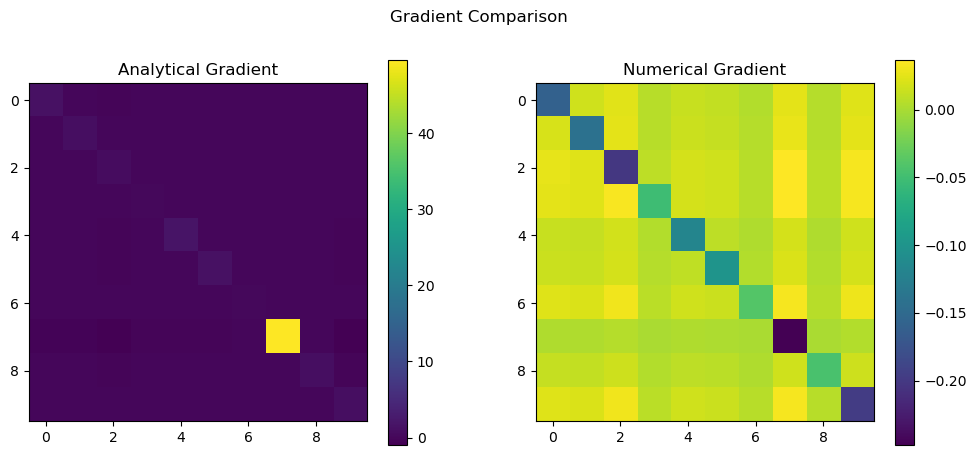

In [42]:
import matplotlib.pyplot as plt

def plot_gradients(analytical, numerical, title="Gradient Comparison"):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(analytical, cmap='viridis', interpolation='none')
    plt.title('Analytical Gradient')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(numerical, cmap='viridis', interpolation='none')
    plt.title('Numerical Gradient')
    plt.colorbar()
    
    plt.suptitle(title)
    plt.show()

# Example usage
plot_gradients(gradient_analytical, gradient_numerical)


In [ ]:
results_pfl_no_fair

{'mean_train_loss': array([60903.12851563, 56993.659375  , 53836.2       , 51214.68515625,
        48730.88125   , 46723.72773438, 44827.02109375, 43266.80429688,
        41752.16738281, 40773.41230469, 39618.38808594, 38786.85839844,
        37917.27285156, 37238.38105469, 36690.44042969, 36146.01894531,
        35775.61972656, 35341.83027344, 35127.959375  , 34858.00332031,
        34599.8796875 , 34475.50996094, 34373.17128906, 34281.24375   ,
        34192.80957031, 34106.21796875, 34225.028125  , 34116.97753906,
        34318.85742188, 34452.37910156, 34614.31601563, 34707.21054688,
        34937.52851563, 35296.01035156, 35643.78222656, 35799.94023437,
        35957.74257812, 36137.90976563, 36322.21289062, 36430.4765625 ]),
 'mean_test_regret': array([15.34060831, 14.45572958, 13.67472105, 12.98632784, 12.38517103,
        11.83770981, 11.35554447, 10.93440161, 10.57026052, 10.26203527,
         9.99603424,  9.76169376,  9.55877237,  9.38619881,  9.241047  ,
         9.11970425,

In [ ]:
results_pfl_with_fair

{'mean_train_loss': array([60849.25234375, 57029.865625  , 53938.22382813, 51359.38046875,
        48885.19296875, 47085.78984375, 45170.04335937, 43684.13789063,
        42272.91328125, 41009.53671875, 40066.77734375, 39094.27539062,
        38333.83222656, 37751.38847656, 37023.09179688, 36481.65097656,
        36079.03105469, 35696.33125   , 35589.58046875, 35163.15800781,
        35120.97148437, 34924.22460938, 34849.55117187, 34709.33925781,
        34664.55546875, 34722.00878906, 34667.81835938, 34710.17089844,
        34950.11230469, 35150.60507813, 35242.88144531, 35612.76875   ,
        35997.99726563, 36116.334375  , 36507.65371094, 36754.284375  ,
        37025.91660156, 37157.24003906, 37440.33027344, 37529.91601562]),
 'mean_test_regret': array([15.35736036, 14.48817272, 13.72154779, 13.04884672, 12.4628396 ,
        11.92827091, 11.45567245, 11.04098358, 10.68326035, 10.3794425 ,
        10.11840572,  9.88831062,  9.68713093,  9.51412621,  9.36693153,
         9.24184875,

In [ ]:
results_dfl_with_fair

{'mean_train_loss': array([60737.50234375, 55875.54882812, 51836.80976563, 48394.83125   ,
        45287.62070313, 42873.92851562, 40639.14804688, 38559.7734375 ,
        36810.11269531, 35011.78535156, 33221.70585937, 31831.29804687,
        30490.83125   , 29187.83007812, 28023.34257813, 27197.36289063,
        26637.59941406, 26048.8078125 , 25283.88867188, 25101.11816406,
        25176.06347656, 25104.66953125, 25365.04667969, 26006.50898437,
        26285.96640625, 27000.54648438, 28408.91464844, 30281.22167969,
        32218.24003906, 34292.16269531, 37100.17441406, 39316.49433594,
        38613.23671875, 37272.08320313, 34934.39941406, 33395.96953125,
        31065.30546875, 29964.25683594, 29064.49375   , 28103.40449219]),
 'mean_test_regret': array([14.90617199, 13.66853027, 12.61317587, 11.69100409, 10.91155443,
        10.18680515,  9.49903889,  8.86084547,  8.26386147,  7.69694071,
         7.15590672,  6.64829202,  6.1701817 ,  5.72264285,  5.30968685,
         4.92866111,

In [ ]:
results_dfl_with_fair_fin_diff_1

{'mean_train_loss': array([60762.003125  , 59005.48789063, 57323.9890625 , 55591.29765625,
        54241.02617187, 53114.0625    , 52145.2171875 , 51069.225     ,
        50323.96132812, 49458.11953125, 48734.44648438, 48314.70664063,
        48214.04375   , 48020.00429687, 47633.5484375 , 47506.30234375,
        47565.84023437, 47544.49414062, 47108.21367187, 47250.15234375,
        46946.96875   , 46716.14570313, 46685.0140625 , 46379.61601562,
        46250.66484375, 45855.61347656, 45500.33183594, 45647.37480469,
        45276.18027344, 45297.02050781, 45374.37636719, 45538.50957031,
        45694.18808594, 45307.87285156, 45616.71621094, 45761.80878906,
        45630.15410156, 45725.19824219, 46056.49199219, 45996.34472656]),
 'mean_test_regret': array([15.80002317, 15.23251305, 14.66294413, 14.24277382, 13.85871696,
        13.45650291, 13.10992489, 12.81839027, 12.55122337, 12.34437418,
        12.15494423, 12.02419949, 11.86564026, 11.78670163, 11.69343004,
        11.61707897,

In [ ]:
results_dfl_with_fair_fin_diff_2

{'mean_train_loss': array([60707.67109375, 59703.81328125, 58869.525     , 57923.61992187,
        57151.54414063, 56332.9203125 , 55542.38398438, 54930.72148437,
        54104.45859375, 53158.30664062, 52367.3703125 , 51582.44726562,
        50919.91015625, 49915.23203125, 48985.73261719, 48229.00761719,
        47427.86074219, 46271.25839844, 45405.15722656, 44470.85996094,
        43619.47832031, 42944.64101562, 42484.87382812, 40712.04882812,
        40107.00644531, 39436.96289062, 38596.98847656, 38120.04589844,
        37418.37519531, 37040.41816406, 36762.74882812, 36744.74609375,
        36767.97714844, 38180.34003906, 39256.05097656, 40843.58691406,
        42649.23457031, 44595.309375  , 47197.3796875 , 49858.60976562]),
 'mean_test_regret': array([16.10766287, 15.80607529, 15.53953571, 15.30948162, 15.08972187,
        14.87864733, 14.68677111, 14.4618928 , 14.23953733, 14.01074533,
        13.7729394 , 13.50447245, 13.23502121, 12.96275826, 12.69284058,
        12.41082373,

In [ ]:
dfl_results_findiff_solver = "All trials completed in 1701.70 seconds Mean trial time: 850.85 ± 37.69 seconds"

{'mean_train_loss': array([61443.9140625]),
 'mean_test_regret': array([14.64962482]),
 'mean_test_mse': array([49.36053848]),
 'mean_test_fair': array([0.01279557]),
 'std_train_loss': array([2550.45703125]),
 'std_test_regret': array([0.24145985]),
 'std_test_mse': array([1.21135712]),
 'std_test_fair': array([0.00621068]),
 'total_times': 1.2009124755859375,
 'mean_time': 0.6004562377929688,
 'std_time': 0.08707904815673828,
 'all_train_time': [0.687535285949707, 0.5133771896362305]}

In [ ]:
results_dfl_no_fair

{'mean_train_loss': array([60765.66757813, 55720.55195313, 51903.78320312, 48306.52304688,
        45463.18945312, 42911.05351562, 40605.33730469, 38641.39667969,
        36708.31113281, 34984.56035156, 33529.30449219, 31796.85585937,
        30509.73125   , 29430.12714844, 28131.57558594, 27386.68847656,
        26848.18007812, 25775.03613281, 25276.27539062, 24964.48535156,
        24870.89550781, 24996.77070312, 25362.43046875, 25766.10175781,
        26835.13496094, 27531.99726562, 28609.32363281, 30059.31015625,
        32110.16484375, 34277.99648437, 37147.6046875 , 38381.62578125,
        38151.13320312, 37359.85117188, 35871.9421875 , 33859.584375  ,
        31667.53125   , 31169.55625   , 29929.9078125 , 29474.00273438]),
 'mean_test_regret': array([14.90523872, 13.66778507, 12.61212597, 11.69142094, 10.90671654,
        10.18218927,  9.49336271,  8.85979843,  8.2602169 ,  7.6950882 ,
         7.15610166,  6.651194  ,  6.17508492,  5.72434521,  5.30362153,
         4.92259693,